In [1]:
import os

import pandas as pd
from tqdm import tqdm

## Load the examples

In [5]:
keywords_gt = pd.read_csv(os.path.join('..', 'data', 'keywords_gt_with_examples.csv'))
# keywords_gt = keywords_gt.rename({'n_keys': 'n_keywords'}, axis=1)
# keywords_gt['presence'] = keywords_gt['presence'].map(lambda x: x if x != 'ERROR' else -1).astype(int)
# keywords_gt.to_csv(os.path.join('..', 'data', 'keywords_gt_with_examples_all.csv'), index=False)

In [6]:
keywords_gt.shape

(1301, 18)

In [7]:
keywords_gt.head()

,country_tag,type,difficulty,r_rsc_id,s_rsc_id,r_pkg_id,s_pkg_id,nl,keywords,prompt_tokens,completion_tokens,presence,response,result_count,top_k,n_keywords,r_id_index,s_id_index
0,CAN,single-table,moderate,a7c95445-e336-41e3-945c-1bc938ff0612,NaN,12c89aa5-063a-f0ed-334a-3019133b9ee8,NaN,What is the total amount paid by each departme...,supplier+payments,1530,372,1,<think>\n\n</think>\n\n## Query Analysis Resul...,17,1000.0,2.0,14.0,NaN
1,CAN,single-table,challenging,a7c95445-e336-41e3-945c-1bc938ff0612,NaN,12c89aa5-063a-f0ed-334a-3019133b9ee8,NaN,Which supplier received the highest payment fr...,new brunswick+supplier,1528,229,1,<think>\n\n</think>\n\n## Query Analysis Resul...,10,1000.0,2.0,7.0,NaN
2,CAN,single-table,simple,ae2204c7-db9e-450e-8158-c70eedada7ae,NaN,4879e498-c9ac-44a3-d7d1-21af22e2224c,NaN,"Which suppliers received payments over $100,00...",suppliers+new brunswick,1530,360,1,<think>\n\n</think>\n\n## Query Analysis Resul...,10,1000.0,2.0,5.0,NaN
3,CAN,single-table,moderate,ae2204c7-db9e-450e-8158-c70eedada7ae,NaN,4879e498-c9ac-44a3-d7d1-21af22e2224c,NaN,According to the Government of New Brunswick’s...,public accounts+new brunswick,1531,356,1,<think>\n\n</think>\n\n## Query Analysis Resul...,34,1000.0,2.0,22.0,NaN
4,CAN,single-table,challenging,ae2204c7-db9e-450e-8158-c70eedada7ae,NaN,4879e498-c9ac-44a3-d7d1-21af22e2224c,NaN,According to the Government of New Brunswick’s...,supplier+new brunswick,1524,204,1,<think>\n\n</think>\n\n## Query Analysis Resul...,10,1000.0,2.0,5.0,NaN


In [8]:
data = keywords_gt[
    (keywords_gt['n_keywords'] == 2) & 
    (keywords_gt['presence'] == 1) &
    (keywords_gt['r_id_index'] < 50) &
    ((keywords_gt['s_id_index'] < 50) | (pd.isna(keywords_gt['s_id_index'])))
].iloc[:].sample(100, random_state=42)

data.shape

(100, 18)

In [9]:
data[(data['r_id_index'] < 30) & (data['s_id_index'] < 30)].shape[0]

7

## Fetching Packages and relative Tables

In [8]:
from ckan import CanadaCKAN

ckan_client = CanadaCKAN() 

In [ ]:
data.iloc[0]['r_pkg_id']

'12c89aa5-063a-f0ed-334a-3019133b9ee8'

In [139]:
r = ckan_client.package_show(id=data.iloc[0]['r_pkg_id'])

In [145]:
del r['result']['resources']

In [147]:
r['result']

{'aggregate_identifier': '',
 'association_type': [],
 'audience': [],
 'author': None,
 'author_email': None,
 'collection': 'federated',
 'contact_information': '{"fr": {"organization_name": "Finances et Conseil du Trésor","electronic_mail_address": "opendatadonneesouvertes@snb.ca"},"en": {"organization_name": "Finance and Treasury Board","electronic_mail_address": "opendatadonneesouvertes@snb.ca"}}',
 'contributor': {},
 'creator_user_id': 'b88b9549-3a4b-43a9-9375-5f3fc20fe782',
 'data_series_issue_identification': {},
 'data_series_name': {},
 'date_published': '2021-10-28 00:00:00',
 'display_flags': [],
 'federated_date_modified': '2024-07-09',
 'file_id': '12c89aa5-063a-f0ed-334a-3019133b9ee8',
 'frequency': 'unknown',
 'geographic_region': [],
 'hierarchy_level': 'dataset; jeuDonnées',
 'id': '12c89aa5-063a-f0ed-334a-3019133b9ee8',
 'imso_approval': 'true',
 'isopen': False,
 'jurisdiction': 'provincial',
 'keywords': {'en': ['supplier lists',
   'listes de fournisseurs',
   'p

In [9]:
import os
import shutil

shutil.rmtree('tmp')
os.makedirs('tmp', exist_ok=True)

cnt = ckan_client.download_tables_from_package_search('tmp', 'csv', 3, q='suppliers+payments', rows=20, defType='edismax', sort='sort desc')

cnt

https://open.canada.ca/data/api/3/action/package_search?q=suppliers+payments&rows=20&defType=edismax&sort=sort desc


53

In [10]:
resource_ids = list(map(lambda s: s.removesuffix('.csv'), os.listdir('tmp')))

data['r_rsc_id'][0] in resource_ids, data['s_rsc_id'][0] in resource_ids

(True, True)

## Setup the BLEND index with ALL the downloaded resources

In [7]:
import blend

searcher = blend.BLEND(os.path.join('data', 'blend.db'))

In [8]:
searcher._db_handler

In [10]:
import duckdb
dbcon = duckdb.connect(os.path.join('data', 'blend.db'))
dbcon.close()

In [4]:
dbcon.sql("DROP TABLE IF EXISTS AllTables CASCADE;")

In [ ]:
subset_ids = os.listdir(os.path.join('data', 'tmp'))[:10]
searcher.create_index(os.path.join('data', 'tmp'), subset_ids, max_workers=6, limit_table_rows=100, verbose=True)

Parsing and storing tables:   0%|          | 0/10 [00:45<?, ?it/s]


In [5]:
import duckdb

dbcon = duckdb.connect(os.path.join('data', 'blend.db'))
dbcon.table('AllTables').show()

┌──────────────────────────────────────────────┬──────────────────────────────────────┬──────────┬────────┬──────────────────┬─────────────┬──────────┬──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│                  CellValue                   │               TableId                │ ColumnId │ RowId  │ GranularityClass │ Granularity │ Quadrant │                                                             SuperKey                                                             │
│                   varchar                    │               varchar                │  uint32  │ uint32 │     varchar      │   varchar   │ boolean  │                                                               blob                                                               │
├──────────────────────────────────────────────┼──────────────────────────────────────┼──────────┼────────┼──────────────────┼─────────────┼──────────┼

In [141]:
dbcon.sql("SELECT COUNT(*) FROM AllTables;")

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│         2288 │
└──────────────┘

In [ ]:
import os
import re
from typing import Dict, List, Literal

import polars as pl

from blend import BLEND


def search_single_joins(
    tables_path: str,
    searcher: BLEND | None = None,
    db_path: str | None = None,
    table_ids: List[str] | None = None,
    format: Literal["csv", "parquet"] = "csv",
    join_on_columns: Dict[str, List[int]] | None = None,
    k: int = 3,
    **blend_kwargs,
) -> List[Dict]:
    """
    Run a single-column-join search on the given tables.

    :param tables_path: directory where table (CSV/parquet) files are stored.
    :param searcher: an instance of BLEND searcher. If None, db_path is required to create a new one.
    :param db_path: a path where to store the BLEND database, required if searcher parameter is None.
    :param table_ids: a subset of table IDs (without any type extension) to use for the search. If None, all tables are used.
    :param format: format of tables. Default is CSV.
    :param join_on_columns: a dictionary where, for each table,
                            is provided a list of columns on which the search is performed.
                            If None, the search is done over every column of every tables.
    :param k: number of results to return for each search.
    :param blend_kwargs: keyword arguments passed to blend.create_index.
    :return: a list of dictionaries, where each reports the pair of tablees and columns and the relative overlap.
    """

    # take table IDs
    table_ids = list(filter(
        lambda _id: True if table_ids is None else _id in table_ids,
        map(lambda _id: re.sub(r"(.csv|.parquet)$", "", _id), os.listdir(tables_path)),
    ))

    if not searcher:
        searcher = BLEND(db_path)
        searcher.create_index(data_path=tables_path, **blend_kwargs)

    results = []

    for table_id in table_ids:
        n_rows = blend_kwargs.get("limit_table_rows", None)

        # read the current query table
        match format:
            case "csv":
                df = pl.read_csv(
                    os.path.join(tables_path, table_id + ".csv"), n_rows=n_rows
                )
            case "parquet":
                df = pl.read_parquet(
                    os.path.join(tables_path, table_id + ".parquet"), r_rows=n_rows
                )

        # for each column, perform a signle-join-search
        for column in df.columns:
            # if this column is not in the subset of
            # selected columns for this table, continue
            if (
                join_on_columns
                and table_id in join_on_columns
                and column not in join_on_columns[table_id]
            ):
                continue

            query_values = df.get_column(column).to_list()

            # perform the search with BLEND
            res = searcher.single_column_join_search(query_values, k)

            for res_table_id, res_column_id, overlap in res:
                match format:
                    case "csv":
                        r_df = pl.read_csv(
                            os.path.join(tables_path, res_table_id + ".csv"), n_rows=0
                        )
                    case "parquet":
                        r_df = pl.read_parquet(
                            os.path.join(tables_path, res_table_id + ".parquet"),
                            r_rows=0,
                        )

                results.append(
                    {
                        "left_table": table_id,
                        "left_column": column,
                        "right_table": res_table_id,
                        "right_column": r_df.columns[res_column_id],
                        "overlap": overlap,
                    }
                )

    return results


def main():
    pass


if __name__ == "__main__":
    main()


In [5]:
import re 

query_tables = os.listdir(os.path.join('data', 'tmp'))[11:13]
query_tables = list(map(lambda _id: re.sub(r"(\.csv|\.parquet)", "", _id), query_tables))

results = search_single_joins(os.path.join('data', 'tmp'), searcher, os.path.join('data', 'blend.db'), query_tables)

['f4b00406-0e71-4ac1-b78b-0faa732a210e', '77296379-7101-4638-a0e8-ad779996f010']


In [6]:
results

[{'left_table': 'f4b00406-0e71-4ac1-b78b-0faa732a210e',
  'left_column': 'Payment / Paiement',
  'right_table': 'f838d643-e46c-4c90-adf2-d5b8ea694298',
  'right_column': 'Payment / Paiement',
  'overlap': 10},
 {'left_table': 'f4b00406-0e71-4ac1-b78b-0faa732a210e',
  'left_column': 'Payment / Paiement',
  'right_table': '18c17dcf-617d-44d7-b351-6fd7c3fc6b48',
  'right_column': 'Amount',
  'overlap': 4},
 {'left_table': 'f4b00406-0e71-4ac1-b78b-0faa732a210e',
  'left_column': 'Payment / Paiement',
  'right_table': 'a99c50a4-a2f8-4613-9f51-2c5ebb6f4445',
  'right_column': 'Payment / Paiement',
  'overlap': 3},
 {'left_table': '77296379-7101-4638-a0e8-ad779996f010',
  'left_column': 'Payment / Paiement',
  'right_table': 'f838d643-e46c-4c90-adf2-d5b8ea694298',
  'right_column': 'Payment / Paiement',
  'overlap': 100},
 {'left_table': '77296379-7101-4638-a0e8-ad779996f010',
  'left_column': 'Payment / Paiement',
  'right_table': 'a99c50a4-a2f8-4613-9f51-2c5ebb6f4445',
  'right_column': 'Pa

In [ ]:
s_rsc_metadata = ckan_client.resource_show(resource_id=data['s_rsc_id'][0])

In [ ]:
response = ckan_client.package_search("payment+supplier", 3)

## Packages pre-filtering

If we can **pre-filter** tables by checking their relevance from package metadata, we can download and post-process **few data** and **reduce the search space** for the subsequent table-selector agent

### Setup Agent and Prompts

In [4]:
import os

from dotenv import load_dotenv
from autogen_core.models import UserMessage
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.messages import StructuredMessage
from autogen_agentchat.ui import Console
from autogen_ext.models.openai import OpenAIChatCompletionClient

In [5]:
# same seed for any random operation
seed = 42

# Load environment variables from .env file
load_dotenv()
assert "TOGETHER_API_KEY" in os.environ

settings = {
    "model": "Qwen/Qwen3-235B-A22B-fp8-tput",
    "temperature": 0.1,
    "top_p": 1,
    "frequency_penalty": 0,
    "presence_penalty": 0,
    "max_tokens": 10000,
}

model_client = OpenAIChatCompletionClient(
    base_url = "https://api.together.xyz/v1/",
    api_key=os.getenv("TOGETHER_API_KEY", ""),
    model_info= {
        "vision": False,
        "function_calling": True,
        "json_output": True,
        "family": "unknown",
        "structured_output": True
    },
    **settings   
)

In [91]:
with open(os.path.join('prompts', 'TablePreFilter.md')) as file:
    TABLE_PRE_FILTER_SYSTEM_PROMPT = file.read()

with open(os.path.join('prompts', 'TablePreFilter-task.md')) as file:
    TABLE_PRE_FILTER_TASK_PROMPT = file.read()

with open(os.path.join('prompts', 'TablePreFilter-allatonce.md')) as file:
    TABLE_PRE_FILTER_ALL_SYSTEM_PROMPT = file.read()

TABLE_PRE_FILTER_ALL_TASK_QUESTION_PROMPT = "<question>{question}</question>"
TABLE_PRE_FILTER_ALL_TASK_PACKAGE_PROMPT = "<package>{title}</package><notes>{notes}</notes>"

In [74]:
# analyze packages one-by-one, 
# without a overall view of available packages
analyzer = AssistantAgent(
    name="TablePreFilter", 
    model_client=model_client, 
    system_message=TABLE_PRE_FILTER_SYSTEM_PROMPT
)

In [92]:
# analyze packages all-at-once
analyzer_all = AssistantAgent(
    name="TablePreFilter_all", 
    model_client=model_client, 
    system_message=TABLE_PRE_FILTER_ALL_SYSTEM_PROMPT
)

### Prepare data for querying the agent

In [68]:
data

,country_tag,type,difficulty,r_rsc_id,s_rsc_id,r_pkg_id,s_pkg_id,r_col_name,s_col_name,nl,top_k,n_keywords,keywords,presence,result_count,r_id_index,s_id_index,prompt_tokens,completion_tokens,response
0,CAN,multi-table-join,simple,ce336623-43d6-4e5d-81d8-26fb9145cf92,ab5df4ac-7f55-461b-934f-d7af48d18e6f,2f40fb8f-a9e7-4f5b-94e9-04fbfaa10676,2013c544-62e8-4485-ad4b-6e5ba5e373b9,coa_segment_04_l3_and_desc,coa_segment_04_l3_and_desc,How do the operating expenses for different fi...,1000,2,british columbia+operating expenses,1,47,0.0,31.0,649,19,<think>\n\n</think>\n\n<keywords>british colum...


In [69]:
keywords = data['keywords'][0]
keywords

'british columbia+operating expenses'

In [100]:
from ckan import CanadaCKAN

ckan_client = CanadaCKAN() 

ckan_response = ckan_client.package_search(q=keywords, rows=50, defType='edismax', sort='sort desc')

https://open.canada.ca/data/api/3/action/package_search?q=british columbia+operating expenses&rows=50&defType=edismax&sort=sort desc


In [101]:
packages = ckan_response['result']['results']

In [102]:
data['nl'][0]

"How do the operating expenses for different fiscal years compare between the 2018 and 2023 supplementary estimates for various ministries in the Government of British Columbia budget? Specifically, I'm interested in seeing the alignment of these expenses based on their specific cost categories like salaries and benefits or operating costs."

In [105]:
desired_package_ids = [data['r_pkg_id'][0], data['s_pkg_id'][0]]

In [106]:
for d in desired_package_ids:
    s = False
    for p in packages:
        if p['id'] == d:
            s = True
            break
    print(d, s)

2f40fb8f-a9e7-4f5b-94e9-04fbfaa10676 True
2013c544-62e8-4485-ad4b-6e5ba5e373b9 True


### Query the Agent

In [ ]:
# ask the agent for an answer. If no_think=True, the thinking process is truncated.
# A much shorter time is required for this option
no_think = False
model_choices = []

for package in tqdm(packages[:0]):
    # print(package['title'])
    # print(package['notes'])
    # print(', '.join(package['keywords']['en']))
    # print()
    prompt = TABLE_PRE_FILTER_TASK_PROMPT.format(
        question=data['nl'][0],
        title=package['title'],
        # notes='N/A', 
        notes=package['notes'][:300],
        keywords='N/A' # ', '.join(package['keywords']['en'])
        # keywords=', '.join(package['keywords']['en'])
    )

    if no_think:
        prompt = '/nothink' + ' ' + prompt

    response = await analyzer.run(task=prompt)
    response = response.messages[-1]
    model_choices.append(response)

100%|██████████| 17/17 [06:10<00:00, 21.77s/it]


In [113]:
# ask the agent for an answer. If no_think=True, the thinking process is truncated.
# A much shorter time is required for this option
no_think = True
model_allatonce_choices = []

prompt = TABLE_PRE_FILTER_ALL_TASK_QUESTION_PROMPT
prompt = prompt.format(question=data['nl'][0])

for package in packages:
    prompt += TABLE_PRE_FILTER_ALL_TASK_PACKAGE_PROMPT.format(
        title=package['title'],
        notes=package['notes'][:200]
    ) + '\n'

if no_think:
    prompt = '/nothink' + ' ' + prompt

response = await analyzer_all.run(task=prompt)
response = response.messages[-1]
model_allatonce_choices.append(response)

In [127]:
analyzer_all.create

AttributeError: 'AssistantAgent' object has no attribute 'create'

In [114]:
# extract the YES/NO answer from the agent reply
import re

answers = [
    re.search(r"<answer>(YES|NO)</answer>", message.content).group(1)
    for message in model_choices
]

answers = list(zip(answers, [p['id'] for p in ckan_response['result']['results']]))
answers = [a[1] for a in answers if a[0] == 'YES']
# answers

In [116]:
answers = re.findall(r"<package>(.*)</package><answer>(YES|NO)</answer>", model_allatonce_choices[0].content)
answers = [(i['id'], a[0]) for i, a in zip(packages, answers) if a[1] == 'YES']
selected_ids = [a[0] for a in answers]
answers

[('2f40fb8f-a9e7-4f5b-94e9-04fbfaa10676',
  'Budget 2023 - Supplement to the Estimates'),
 ('2013c544-62e8-4485-ad4b-6e5ba5e373b9',
  'Budget 2018 - Supplement to the Estimates')]

In [117]:
for i, package in tqdm(enumerate(ckan_response['result']['results'])):
    if package['id'] in selected_ids:
        print(str(i) + ' ' + package['id'])
        print(str(i) + ' ' + package['title'])
        # print(package['notes'][:300])
    if package['id'] in desired_package_ids:
        print(str(i) + ' ' + '>>> ' + package['id'])
        print(str(i) + ' ' + '>>> ' + package['title'])

47it [00:00, 70203.81it/s]

0 2f40fb8f-a9e7-4f5b-94e9-04fbfaa10676
0 Budget 2023 - Supplement to the Estimates
0 >>> 2f40fb8f-a9e7-4f5b-94e9-04fbfaa10676
0 >>> Budget 2023 - Supplement to the Estimates
31 2013c544-62e8-4485-ad4b-6e5ba5e373b9
31 Budget 2018 - Supplement to the Estimates
31 >>> 2013c544-62e8-4485-ad4b-6e5ba5e373b9
31 >>> Budget 2018 - Supplement to the Estimates


In [86]:
desired_package_ids[0], desired_package_ids[0] in selected_ids, desired_package_ids[1], desired_package_ids[1] in selected_ids

('2f40fb8f-a9e7-4f5b-94e9-04fbfaa10676',
 True,
 '2013c544-62e8-4485-ad4b-6e5ba5e373b9',
 False)

In [87]:
data['nl'][0]

"How do the operating expenses for different fiscal years compare between the 2018 and 2023 supplementary estimates for various ministries in the Government of British Columbia budget? Specifically, I'm interested in seeing the alignment of these expenses based on their specific cost categories like salaries and benefits or operating costs."

In [111]:
with open('answers/missing_package_with_all_packages.txt', 'w') as file:
    file.write(model_allatonce_choices[0].content)

In [121]:
model_allatonce_choices[0]

TextMessage(id='14cc1647-8bbe-4bfa-9e7c-9b0d2a4ef513', source='TablePreFilter_all', models_usage=RequestUsage(prompt_tokens=11346, completion_tokens=1506), metadata={}, created_at=datetime.datetime(2025, 7, 25, 9, 19, 57, 712520, tzinfo=datetime.timezone.utc), content='<think>\n\n</think>\n\n<package>Budget 2023 - Supplement to the Estimates</package><answer>YES</answer>  \n<package>Operating Statement Tbl 2.1</package><answer>NO</answer>  \n<package>Historical Operating Statement Surplus (Deficit) Tbl A2.14</package><answer>NO</answer>  \n<package>BC Finance - Standard Object of Expense</package><answer>NO</answer>  \n<package>Budget 2013 June Update - Provincial Debt Summary Tbl 1.17</package><answer>NO</answer>  \n<package>Historical Operating Statement Surplus (Deficit), 1969-1970 to 2011-12 Tbl A2.14</package><answer>NO</answer>  \n<package>Budget 2012 - Provincial Debt Tbl 1.20</package><answer>NO</answer>  \n<package>Budget 2014 - Ten-Year Operating Statement 2007-08 to 2016-17 

### Results from evaluate_allatonce.py

In [132]:
import os
import pandas as pd

df = pd.read_csv(os.path.join('data', 'allatonce_evaluation_k30.csv'))
df = pd.read_csv(os.path.join('data', 'embedding_eval_k30.csv'))

In [133]:
X = df[['r_present', 'r_selected']].dropna().map(int)
y_true = X['r_present'].values.reshape((-1, 1))
y_pred = X['r_selected'].values.reshape((-1, 1))
y_true.shape, y_pred.shape

((100, 1), (100, 1))

In [134]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)


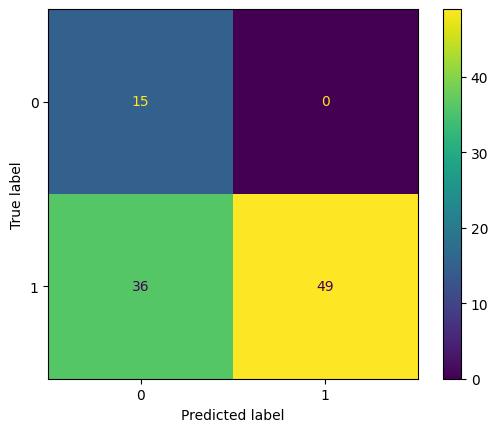

In [135]:
import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

## Resources Pre-Filtering

Once we have selected a small subset of all the available packages, again we can choose which resources satisfy us most: a model should avoid to download same datasets from different formats (e.g. CSV and XLSX) or languages (EN vs FR)

In [10]:
from ckan import CanadaCKAN

ckan_client = CanadaCKAN()

In [133]:
i = 23
idx = data.index[i]
question = data.loc[idx]['nl']
r_pkg_id = data.loc[idx]['r_pkg_id']
s_pkg_id = data.loc[idx]['s_pkg_id']
r_rsc_id = data.loc[idx]['r_rsc_id']
r_pkg_id, s_pkg_id

('a5cb7c3c-0371-4a20-ac9a-98fc4c3536bb', nan)

In [134]:
package_metadata = ckan_client.package_show(id=r_pkg_id)['result']

In [135]:
r_rsc_id

'fb79c2c3-27fe-454e-b9ee-6d1049ea41eb'

In [136]:
from tabulate import tabulate

x = []
for r in package_metadata['resources']:
    x.append((r['name'], r['id'], '<<<' if r['id'] == r_rsc_id else ''))
print(tabulate(x))

---------------------------------------------  ------------------------------------  ---
Appendix B1 of 2020-2021 NCRMP Report EN       001d3db4-8af8-4259-a017-09604beab006
Appendix B1 of 2020-2021 NCRMP Report FR       e0b83ef3-40d0-470b-90df-62699ab742d1
Appendix B2 of 2020-2021 NCRMP Report EN       73358490-423c-4b54-a6e1-383828e4efd7
Appendix B2 of 2020-2021 NCRMP Report FR       c541e163-6fb9-472d-9b48-97d067c84a5f
Appendix B3 of 2020-2021 NCRMP Report EN       fb79c2c3-27fe-454e-b9ee-6d1049ea41eb  <<<
Appendix B3 of 2020-2021 NCRMP Report FR       6c8b55db-546f-487a-981e-4a5e92224680
Appendix B4 of 2020-2021 NCRMP Report EN       8180a735-fa80-4f54-adeb-072ce0c25611
Appendix B4 of 2020-2021 NCRMP Report FR       02705d98-4402-49df-bdd2-6238e505a17e
Appendix B5 of 2020-2021 NCRMP Report EN       b03de182-7e2b-4818-9228-ad8d0b3c84da
Appendix B5 of 2020-2021 NCRMP Report FR       8929476e-21b7-421f-8aeb-a9108d4bcb1c
Appendix B6 of 2020-2021 NCRMP Report EN       bff2426f-7c57-49e0-

In [132]:
question

"According to Statistics Canada's data on new housing prices, what are the average values of the indexes for houses and land across various base years when there is no reported status?"

A first simple filter is on data format: ONLY CSVs are ACCEPTED

Another one is on language: here we want to work only on ENGLISH resources

In [127]:
res = package_metadata['resources'][:]

apply_filters = True

def format_f(resource):
    return resource['format'] == 'CSV'

def language_f(resource):
    return 'language' in resource and 'en' in resource['language']

def resource_type_f(resource):
    return 'resource_type' in resource and resource['resource_type'] == 'dataset'


if apply_filters:
    res = list(
        filter(format_f, 
               filter(language_f, 
                      filter(resource_type_f, res
                    )
                )
            )
        )

keys = res[0].keys()

x = []

for r in res:
    v = ['>>>' if r['id'] == r_rsc_id else '']
    for k in keys:
        if k in r:
            v.append(r[k])
        else:
            v.append(None)
    x.append(v)



print(tabulate(x, headers=['resource'] + list(keys)))

resource    cache_last_updated    cache_url    character_set    created                     data_quality            datastore_active    datastore_contains_all_records_of_source_file    date_published    description    format    hash    id                                    language    last_modified    metadata_modified           mimetype    mimetype_inner    name                                                          name_translated                                                                                                                                      package_id                              position  resource_type    state    unique_identifier    url                                                                                                                                                                     url_type
----------  --------------------  -----------  ---------------  --------------------------  ----------------------  ------------------  ------------------

In [60]:
keys

dict_keys(['cache_last_updated', 'cache_url', 'character_set', 'created', 'data_quality', 'datastore_active', 'datastore_contains_all_records_of_source_file', 'date_published', 'description', 'format', 'hash', 'id', 'language', 'last_modified', 'metadata_modified', 'mimetype', 'mimetype_inner', 'name', 'name_translated', 'package_id', 'position', 'related_relationship', 'related_type', 'resource_type', 'state', 'unique_identifier', 'url', 'url_type'])

In [73]:
keys

dict_keys(['aafc_resource_metadata_schema', 'aafcdc_evaluation_feedback', 'cache_last_updated', 'cache_url', 'character_set', 'created', 'data_quality', 'data_source_repository', 'datastore_active', 'datastore_contains_all_records_of_source_file', 'date_published', 'description', 'format', 'hash', 'id', 'language', 'last_modified', 'metadata_modified', 'mimetype', 'mimetype_inner', 'name', 'name_translated', 'package_id', 'position', 'resource_type', 'selectResourceOption', 'state', 'unique_identifier', 'url', 'url_type'])